In [935]:
import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

Data manipulation

In [936]:
def prepare_data(data):
    data["Spending"]=data["RoomService"]+data["FoodCourt"]+data["ShoppingMall"]+data["Spa"]+data["VRDeck"]
    data["Cabin"]=data["Cabin"].replace(to_replace=numpy.nan,value="Unknown")
    for x in range(len(data)):
        data.loc[x,"Group"]=data.loc[x,"PassengerId"][:4]
    group={}
    for x in range(len(data)):
        g=data.loc[x,"Group"]
        if group.get(g,0)==0:
            group[g]=0
        group[g]+=1
    for x in range(len(data)):
        data.loc[x,"GroupSize"]=group.get(data.loc[x,"Group"])
    return data
def prepare_data2(data):
    data=data[["GroupSize","HomePlanet","Destination","CryoSleep","Age","VIP","Spending","Transported"]]
    data=pandas.get_dummies(data,columns=["Destination","HomePlanet"],drop_first=False)
    age_less_16=data["Age"]<16
    data["IsChild"]=age_less_16
    return data
def prepare_test_data(data):
    data=prepare_data(data)
    data=data[["GroupSize","HomePlanet","Destination","CryoSleep","Age","VIP","Spending"]]
    data=pandas.get_dummies(data,columns=["Destination","HomePlanet"],drop_first=False)
    age_less_16=data["Age"]<16
    data["IsChild"]=age_less_16
    return data
def plot_metrics(y,x,model):
    cm = confusion_matrix(y, model.predict(x))
    ax= plt.subplot()
    seaborn.heatmap(cm, annot=True, ax = ax);
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['false', 'true']); ax.yaxis.set_ticklabels(['false', 'true']) 
    ax.legend()
    plt.show() 
    print("Confusion Matrix: ",cm)
    print("accuracy :",model.score(X=x,y=y))
def data_cleaning(data):
    data["VIP"]=data["VIP"].replace(to_replace=numpy.nan,value=data["VIP"].mean())
    data["CryoSleep"]=data["CryoSleep"].replace(to_replace=numpy.nan,value=data["CryoSleep"].mean())
    data["Age"]=data["Age"].replace(to_replace=numpy.nan,value=data["Age"].mean())
    data["RoomService"]=data["RoomService"].replace(to_replace=numpy.nan,value=data["RoomService"].mean())
    data["FoodCourt"]=data["FoodCourt"].replace(to_replace=numpy.nan,value=data["FoodCourt"].mean())
    data["ShoppingMall"]=data["ShoppingMall"].replace(to_replace=numpy.nan,value=data["ShoppingMall"].mean())
    data["Spa"]=data["Spa"].replace(to_replace=numpy.nan,value=data["Spa"].mean())
    data["VRDeck"]=data["VRDeck"].replace(to_replace=numpy.nan,value=data["VRDeck"].mean())
    return data
def generate_output(model):
    test_data=pandas.read_csv("test.csv")
    data_cleaning(test_data)
    test_data=prepare_test_data(test_data)
    result=pandas.DataFrame({"PassengerId":pandas.read_csv("test.csv")["PassengerId"],"Transported":model.predict(test_data)})
    result.set_index("PassengerId",inplace=True)    
    result.to_csv("titanic_2_output.csv")

In [937]:
train_data=pandas.read_csv("train.csv")
train_data=data_cleaning(train_data)
train_data=prepare_data(train_data)
t=train_data["Transported"]==True
transported=train_data[t]

Influence of categorical variables

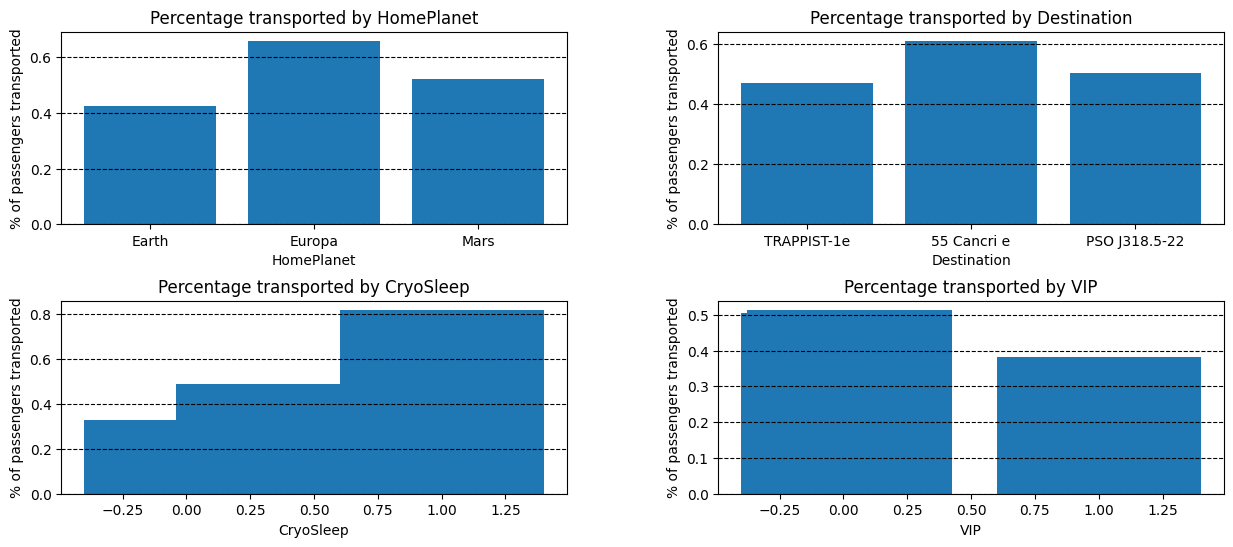

In [938]:
#categorial variables
def plot_transported_percentage(col:str,index:int):
    plt.subplot(index)
    plt.grid(visible=True,axis="y",which="major",color="k",linestyle="--")
    plt.ylabel("% of passengers transported")
    plt.xlabel(col)
    data=transported[col].value_counts()/train_data[col].value_counts()
    data=data.reset_index()
    plt.bar(data[col],height=data["count"])
    plt.title(label="Percentage transported by " + col)
plt.figure(figsize=(15,6))
plot_transported_percentage("HomePlanet",221)
plot_transported_percentage("Destination",222)
plot_transported_percentage("CryoSleep",223)
plot_transported_percentage("VIP",224)
plt.subplots_adjust(hspace=0.4,wspace=0.3)
plt.show()

Influence of continuous variables

In [939]:
train_data[["Age","RoomService","FoodCourt","ShoppingMall","Spa","VRDeck","Transported","Spending"]].corr()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Spending
Age,1.000000,0.067612,0.127937,0.032655,0.120992,0.099210,-0.074249,0.184509
RoomService,0.067612,1.000000,-0.015521,0.052962,0.009925,-0.019207,-0.242048,0.234303
FoodCourt,0.127937,-0.015521,1.000000,-0.013934,0.220587,0.224275,0.046074,0.742208
ShoppingMall,0.032655,0.052962,-0.013934,1.000000,0.013678,-0.007189,0.010019,0.220498
Spa,0.120992,0.009925,0.220587,0.013678,1.000000,0.147957,-0.218791,0.592439
VRDeck,0.099210,-0.019207,0.224275,-0.007189,0.147957,1.000000,-0.204825,0.585835
Transported,-0.074249,-0.242048,0.046074,0.010019,-0.218791,-0.204825,1.000000,-0.199445
Spending,0.184509,0.234303,0.742208,0.220498,0.592439,0.585835,-0.199445,1.000000


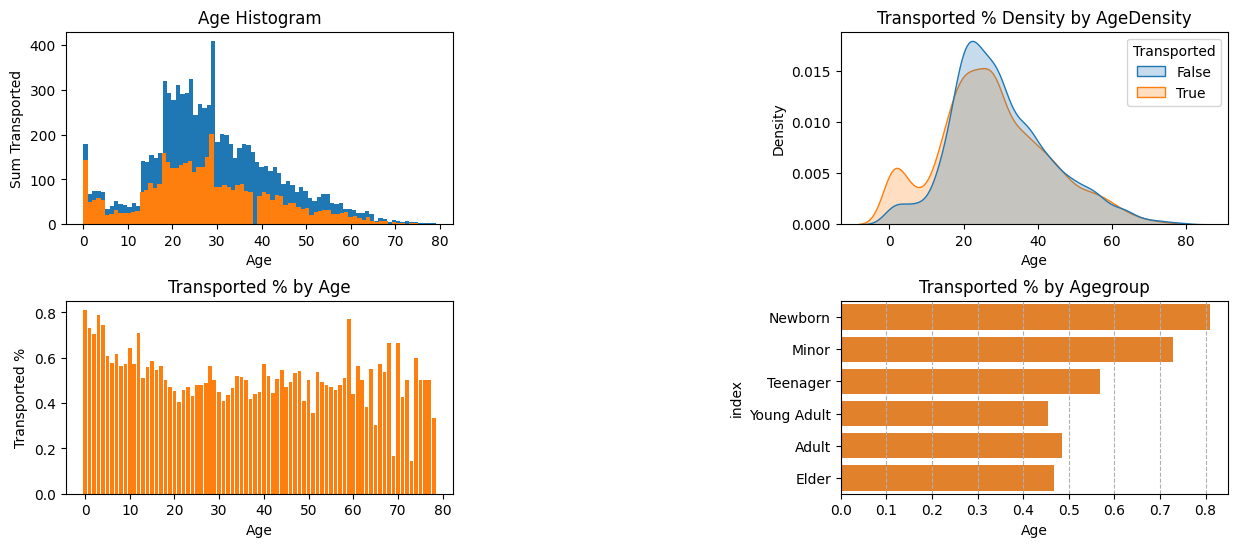

In [940]:
#Age
plt.figure(figsize=(15,6))
plt.subplot(221)
t=train_data["Transported"]==1
t1=train_data[t]
plt.hist(x=train_data["Age"],bins=80)
plt.hist(x=t1["Age"],bins=80)
plt.ylabel("Sum Transported")
plt.xlabel("Age")
plt.title("Age Histogram")

age_map={}
age_map_transported={}
for x in range(len(train_data)):
    age=train_data.loc[x,"Age"]
    if age_map.get(age,-1)==-1:
        age_map[age]=0
        age_map_transported[age]=0
    age_map[age]+=1
    if train_data.loc[x,"Transported"]==1:
        age_map_transported[age]+=1       
age_map_transported_percentage={}
for x in age_map:
    if age_map_transported[x]>0:
        age_map_transported_percentage[x]=age_map_transported[x]/age_map[x]
a=pandas.DataFrame(age_map_transported_percentage,index=["Age"])
a=a.transpose()
a.reset_index(inplace=True)
plt.subplot(223)
plt.bar(x=a["index"],height=a["Age"],color='tab:orange')
plt.xlabel("Age")
plt.ylabel("Transported %")
plt.title("Transported % by Age")
plt.subplots_adjust(hspace=0.4,wspace=1)

plt.subplot(222)
plt.title("Transported % Density by AgeDensity")
seaborn.kdeplot(data=train_data, x="Age", hue="Transported", fill=True)

def get_percentage_by_age_group(start:int,end:int):
    tranported=0
    total=0
    for x in range(start,end):
        total+=age_map.get(x,0)
        tranported+=age_map_transported.get(x,0)
    return tranported/total
newborn=get_percentage_by_age_group(0,1)
minor=get_percentage_by_age_group(1,6)
teenager=get_percentage_by_age_group(6,18)
young_adult=get_percentage_by_age_group(18,25)
adult=get_percentage_by_age_group(25,60)
elder=get_percentage_by_age_group(60,81)
age_groups=[newborn,minor,teenager,young_adult,adult,elder]
age_groups_df=pandas.DataFrame(data=age_groups,columns=["Age"],index=["Newborn","Minor","Teenager","Young Adult","Adult","Elder"])
age_groups_df.reset_index(inplace=True)
plt.subplot(224)
plt.title("Transported % by Agegroup")
#plt.hist(x=train_data["Age"],bins=[0,1,6,14,18,60,81])
#plt.hist(x=t1["Age"],bins=[0,1,6,14,18,60,81])
plt.grid(visible=True,linestyle="--")
seaborn.barplot(data=age_groups_df,x="Age",y="index",color="tab:orange")
plt.show()

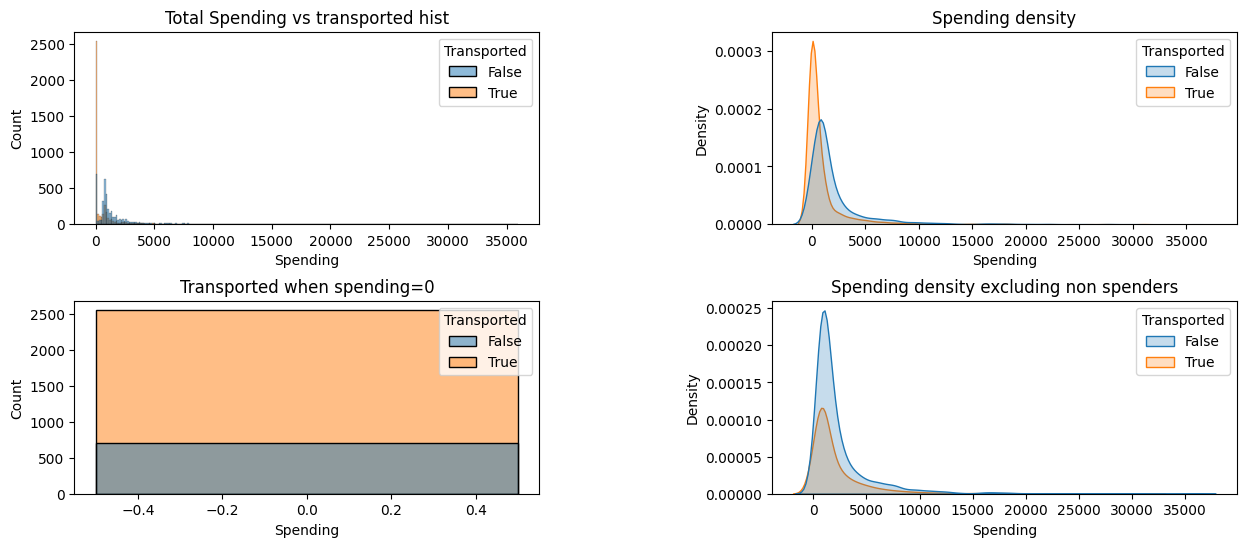

In [941]:
#Spending
plt.figure(figsize=(15,6))
plt.subplots_adjust(hspace=0.4,wspace=0.5)
plt.subplot(221)
plt.title("Total Spending vs transported hist")
seaborn.histplot(data=train_data, x="Spending", hue="Transported")
plt.subplot(222)
plt.title("Spending density")
seaborn.kdeplot(data=train_data, x="Spending", hue="Transported", fill=True)

t1=train_data[t]
plt.subplot(224)
plt.title("Spending density excluding non spenders")
spending_true=train_data["Spending"]>0
spending_true2=train_data[spending_true]
seaborn.kdeplot(data=spending_true2, x="Spending", hue="Transported", fill=True)
plt.subplot(223)
plt.title("Transported when spending=0")
spending_false=train_data["Spending"]==0
spending_false2=train_data[spending_false]
seaborn.histplot(data=spending_false2, x="Spending", hue="Transported", fill=True)

plt.show()


<Axes: title={'center': 'Transported density travelling with entourage'}, xlabel='Entourage', ylabel='Density'>

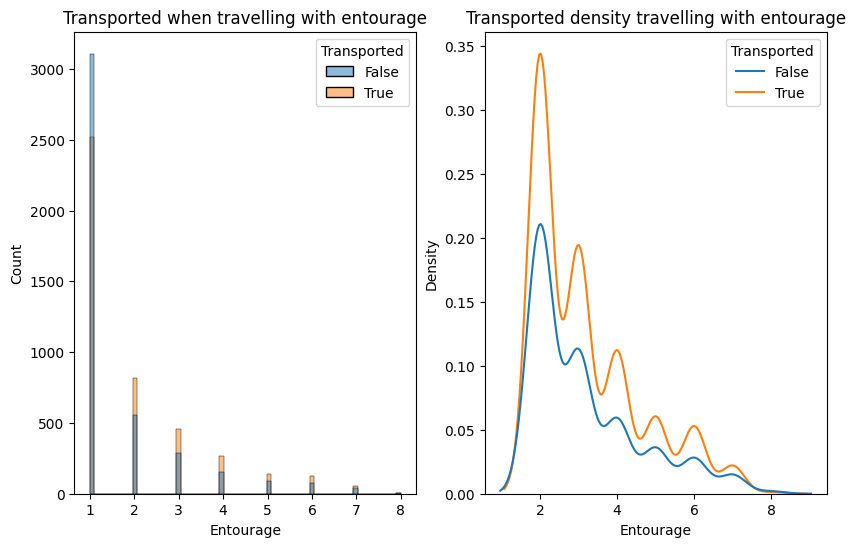

In [942]:
#Cabin occupation
cabin_occupation={}
for x in range(len(train_data)):
    cabin =train_data.loc[x,"Cabin"]
    if cabin_occupation.get(cabin,0)==0:
        cabin_occupation[cabin]=0
    cabin_occupation[cabin]+=1
for x in range(len(train_data)):
    if train_data.loc[x,"Cabin"]=="Unknown":
        train_data.loc[x,"Entourage"]=1
    else:
        train_data.loc[x,"Entourage"]=cabin_occupation.get(train_data.loc[x,"Cabin"])
plt.figure(figsize=(15,6))
et_greater1=train_data["Entourage"]>1
et_greater1_2=train_data[et_greater1]
plt.subplot(131)
plt.title("Transported when travelling with entourage")
seaborn.histplot(data=train_data,x="Entourage",hue="Transported")
et_eq1=train_data["Entourage"]==1
et_eq1_2=train_data[et_eq1]
#plt.subplot(132)
#seaborn.histplot(data=et_eq1_2,x="Entourage",hue="Transported")
plt.subplot(132)
plt.title("Transported density travelling with entourage")
seaborn.kdeplot(data=et_greater1_2,x="Entourage",hue="Transported")


In [943]:
train_data.drop("HomePlanet",axis=1,inplace=True)
train_data.drop("Destination",axis=1,inplace=True)
train_data.drop("Cabin",axis=1,inplace=True)
train_data.drop("Name",axis=1,inplace=True)
transported=train_data["Transported"]
train_data.drop("Transported",axis=1,inplace=True)
X_train,X_test,Y_train,Y_test=train_test_split(train_data,transported,test_size=0.2,train_size=0.8,random_state=10)
#X_train=prepare_data2(train_data)[["GroupSize","CryoSleep","Age","VIP","Spending","Destination_55 Cancri e","Destination_PSO J318.5-22","Destination_TRAPPIST-1e","HomePlanet_Earth","HomePlanet_Europa","HomePlanet_Mars","IsChild"]]
#Y_train=data["Transported"]

C:\Users\Kay\AppData\Local\Temp\ipykernel_14868\4035366970.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


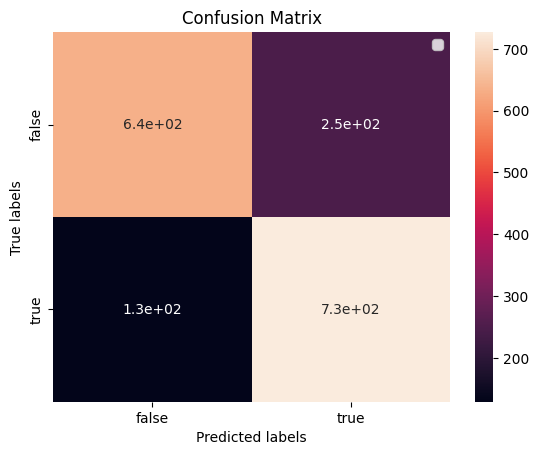

Confusion Matrix:  [[635 248]
 [129 727]]
accuracy : 0.7832087406555491


In [957]:
forest = RandomForestClassifier(n_estimators=300,max_depth=4,random_state=8,max_features=1.0,max_samples=1.0,min_samples_leaf=2,min_samples_split=2)
forest.fit(X_train,Y_train)
plot_metrics(Y_test,X_test,forest)

C:\Users\Kay\AppData\Local\Temp\ipykernel_14868\4035366970.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


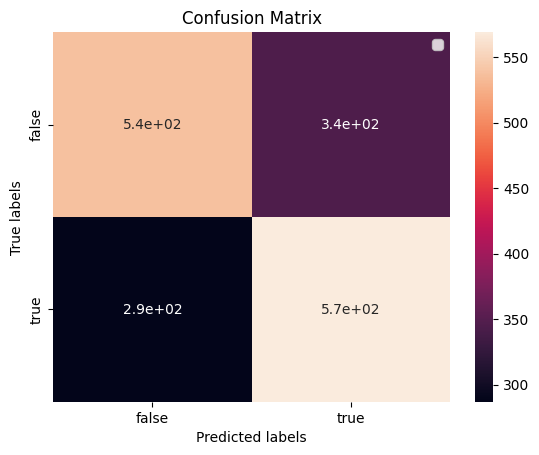

Confusion Matrix:  [[538 345]
 [287 569]]
accuracy : 0.6365727429557216


In [956]:
from sklearn.neighbors import KNeighborsClassifier as KNN
knn= KNN(n_neighbors=10,p=2,leaf_size=30)
knn.fit(X_train,Y_train)
plot_metrics(Y_test,X_test,knn)

In [958]:
generate_output(forest)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Destination_55 Cancri e
- Destination_PSO J318.5-22
- Destination_TRAPPIST-1e
- HomePlanet_Earth
- HomePlanet_Europa
- ...
Feature names seen at fit time, yet now missing:
- Entourage
- FoodCourt
- Group
- PassengerId
- RoomService
- ...


In [ ]:
pandas.DataFrame({"feature":X_train.columns,"Importance":numpy.round(forest.feature_importances_,3)}).sort_values("Importance")


In [ ]:
transported

In [960]:
train_data

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Spending,Group,GroupSize,Entourage
0,0001_01,False,39.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0001,1.0,1.0
1,0002_01,False,24.0,False,109.0,9.0,25.0,549.0,44.0,736.0,0002,1.0,1.0
2,0003_01,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,10383.0,0003,2.0,2.0
3,0003_02,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,5176.0,0003,2.0,2.0
4,0004_01,False,16.0,False,303.0,70.0,151.0,565.0,2.0,1091.0,0004,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,False,41.0,True,0.0,6819.0,0.0,1643.0,74.0,8536.0,9276,1.0,1.0
8689,9278_01,True,18.0,False,0.0,0.0,0.0,0.0,0.0,0.0,9278,1.0,1.0
8690,9279_01,False,26.0,False,0.0,0.0,1872.0,1.0,0.0,1873.0,9279,1.0,1.0
8691,9280_01,False,32.0,False,0.0,1049.0,0.0,353.0,3235.0,4637.0,9280,2.0,2.0
